<h1>Прогнозирование температуры звезды</h1>
<br>
Вам пришла задача от обсерватории «Небо на ладони»: придумать, как с помощью нейросети определять температуру на поверхности обнаруженных звёзд. Обычно для расчёта температуры учёные пользуются следующими методами:
<br>
<br>
<li>
Закон смещения Вина.
</li>
<li>
Закон Стефана-Больцмана.
</li>
<li>
Спектральный анализ.
</li>
<br>
Каждый из них имеет плюсы и минусы. Обсерватория хочет внедрить технологии машинного обучения для предсказания температуры звёзд, надеясь, что этот метод будет наиболее точным и удобным.
<br>
<br>
В базе обсерватории есть характеристики уже изученных 240 звёзд.
<br>
<h2>Характеристики</h2>
<br>
<li>
    Относительная светимость <code>L/Lo</code> — светимость звезды относительно Солнца.
</li>
<li>
Относительный радиус <code>R/Ro</code> — радиус звезды относительно радиуса Солнца.
</li>
<li>
Абсолютная звёздная величина <code>Mv</code> — физическая величина, характеризующая блеск звезды.
</li>
<li>
Звёздный цвет (<code>white</code>, <code>red</code>, <code>blue</code>, <code>yellow</code>, <code>yellow-orange</code> и др.) — цвет звезды, который определяют на основе спектрального анализа.
</li>
<li>
Тип звезды.
<table>
  <tr>
    <th>Тип звезды</th>
    <th>Номер, соответствующий типу</th>
  </tr>
  <tr>
    <td>Коричневый карлик</td>
    <td>0</td>
  </tr>
  <tr>
    <td>Красный карлик</td>
    <td>1</td>
  </tr>
  <tr>
    <td>Белый карлик</td>
    <td>2</td>
  </tr>
  <tr>
    <td>Звёзды главной последовательности</td>
    <td>3</td>
  </tr>
  <tr>
    <td>Сверхгигант</td>
    <td>4</td>
  </tr>
  <tr>
    <td>Гипергигант</td>
    <td>5</td>
  </tr>
</table>

</li>
<li>
Абсолютная температура T(K) — температура на поверхности звезды в Кельвинах.
</li>
<br>
В этом самостоятельном проекте вам необходимо разработать нейронную сеть, которая поможет предсказывать абсолютную температуру на поверхности звезды.
<br>
<br>
<code>💡 Справочная информация:
Светимость Солнца (англ. <em>Average Luminosity of Sun</em>)
L<sub>0</sub> = 3.828 × 10<sup>26</sup> Вт
Радиус Солнца (англ. <em>Average Radius of Sun</em>)
R<sub>0</sub> = 6.9551 × 10<sup>8</sup> М
</code>

## Загрузка данных

Загружаем нужные библиотеки

In [1]:
!pip install scikit-learn skorch
!pip install -U scikit-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import os
import random
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, make_scorer
from skorch import NeuralNetRegressor
from skorch.callbacks import EarlyStopping, EpochScoring
from skorch.dataset import Dataset, ValidSplit


from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error

     |████████████████████████████████| 221 kB 2.1 MB/s eta 0:00:01
     |████████████████████████████████| 10.9 MB 2.1 MB/s eta 0:00:01
     |████████████████████████████████| 302 kB 73.1 MB/s eta 0:00:01
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
      Successfully uninstalled joblib-1.1.0
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.1
    Uninstalling scikit-learn-0.24.1:
      Successfully uninstalled scikit-learn-0.24.1


In [2]:
SEED = 666

Загрузка данных

In [3]:
if os.path.exists('6_class.csv'):
    df = pd.read_csv('6_class.csv', index_col=0)
else:
    df = pd.read_csv('/datasets/6_class.csv', index_col=0)

Проверим данные

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 240 entries, 0 to 239
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Temperature (K)         240 non-null    int64  
 1   Luminosity(L/Lo)        240 non-null    float64
 2   Radius(R/Ro)            240 non-null    float64
 3   Absolute magnitude(Mv)  240 non-null    float64
 4   Star type               240 non-null    int64  
 5   Star color              240 non-null    object 
dtypes: float64(3), int64(2), object(1)
memory usage: 13.1+ KB


In [5]:
display(df.describe().transpose())

,count,mean,std,min,25%,50%,75%,max
Temperature (K),240.0,10497.462500,9552.425037,1939.00000,3344.250000,5776.0000,15055.5000,40000.00
Luminosity(L/Lo),240.0,107188.361635,179432.244940,0.00008,0.000865,0.0705,198050.0000,849420.00
Radius(R/Ro),240.0,237.157781,517.155763,0.00840,0.102750,0.7625,42.7500,1948.50
Absolute magnitude(Mv),240.0,4.382396,10.532512,-11.92000,-6.232500,8.3130,13.6975,20.06
Star type,240.0,2.500000,1.711394,0.00000,1.000000,2.5000,4.0000,5.00


In [6]:
def check_df(data):
    empty_values = data.isnull().sum()
    duplicate_values = data.duplicated().sum()
    distinct_values = data.nunique()
    explore_data = pd.DataFrame({'column': empty_values.index, 
                                 'empty': empty_values.values, 
                                 'duplicated': duplicate_values, 
                                 'distinct': distinct_values.values})
    return explore_data

In [7]:
explore_data = check_df(df)

In [8]:
display(explore_data)

,column,empty,duplicated,distinct
0,Temperature (K),0,0,228
1,Luminosity(L/Lo),0,0,208
2,Radius(R/Ro),0,0,216
3,Absolute magnitude(Mv),0,0,228
4,Star type,0,0,6
5,Star color,0,0,19


In [9]:
def plot_column_diagram(data, column):
    value_counts = data[column].astype(str).value_counts(dropna=False)
    labels = value_counts.index
    counts = value_counts.values
    
    fig, ax = plt.subplots()
    
    colors = ['red' if label == 'nan' or label == '0' else 'black' for label in labels]
    ax.bar(labels, counts, color=colors)
    
    ax.set_xlabel(column)
    ax.set_ylabel('Количество')
    ax.set_title(f'Распределение категориальных значений столбца {column}')
    
    plt.xticks(rotation=90)
    plt.show()
    
    unique_values = data[column].unique()
    print(unique_values)

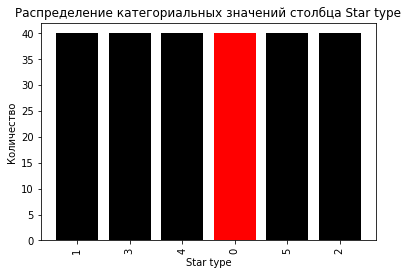

[0 1 2 3 4 5]


In [10]:
plot_column_diagram(df, 'Star type')

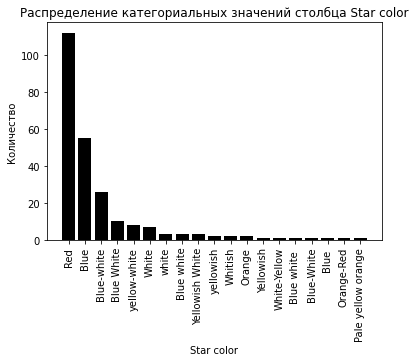

['Red' 'Blue White' 'White' 'Yellowish White' 'Blue white'
 'Pale yellow orange' 'Blue' 'Blue-white' 'Whitish' 'yellow-white'
 'Orange' 'White-Yellow' 'white' 'Blue ' 'yellowish' 'Yellowish'
 'Orange-Red' 'Blue white ' 'Blue-White']


In [11]:
plot_column_diagram(df, 'Star color')

## Предобработка и анализ данных

In [12]:
df.rename(columns={
    'Temperature (K)': 'temperature',
    'Luminosity(L/Lo)': 'luminosity',
    'Radius(R/Ro)': 'radius',
    'Absolute magnitude(Mv)': 'magnitude',
    'Star type': 'star_type',
    'Star color': 'color'
}, inplace=True)

In [13]:
df['color'] = df['color'].str.strip().str.lower().replace(regex=r'\s', value='-')

In [14]:
df['color'] = df['color'].replace(['yellow-white', 'yellowish-white'], 'white-yellow')

In [15]:
df['color'] = df['color'].replace(['whitish'], 'white')

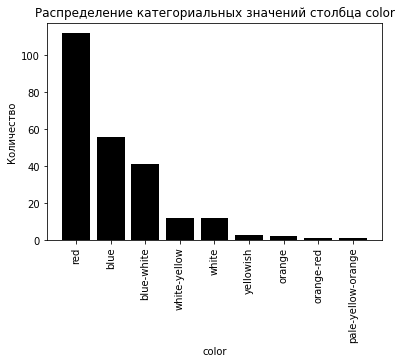

['red' 'blue-white' 'white' 'white-yellow' 'pale-yellow-orange' 'blue'
 'orange' 'yellowish' 'orange-red']


In [16]:
plot_column_diagram(df, 'color')

In [17]:
explore_data = check_df(df)

In [18]:
display(explore_data)

,column,empty,duplicated,distinct
0,temperature,0,0,228
1,luminosity,0,0,208
2,radius,0,0,216
3,magnitude,0,0,228
4,star_type,0,0,6
5,color,0,0,9


In [19]:
X = df.drop(['temperature'], axis=1)
y = df['temperature']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=SEED)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=SEED)

numeric = X.select_dtypes(include=['float64', 'int64']).columns
categorical = X.select_dtypes(include=['object']).columns


numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('scaler', numeric_transformer, numeric),
        ('ohe', categorical_transformer, categorical)
    ],
    remainder="passthrough"
)

X_train_processed = preprocessor.fit_transform(X_train)
X_val_processed = preprocessor.transform(X_val)
X_test_processed = preprocessor.transform(X_test)

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [20]:
y_train = y_train.values.reshape(-1, 1).astype(np.float32)
y_val = y_val.values.reshape(-1, 1).astype(np.float32)

Создание класса для набора данных

In [21]:
class StarDataset(Dataset):
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

## Построение базовой нейронной сети

Создание модели нейронной сети

In [22]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size2, 1)
    
    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.fc3(x)
        return x

Создание датасетов и загрузчиков данных

In [23]:
train_dataset = StarDataset(torch.tensor(X_train_processed, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32).view(-1, 1))

In [24]:
val_dataset = StarDataset(torch.tensor(X_val_processed, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32).view(-1, 1))

In [25]:
test_dataset = StarDataset(torch.tensor(X_test_processed, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32).view(-1, 1))

In [26]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [27]:
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [28]:
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Обучение модели

In [29]:
def rmse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, squared=False)

In [30]:
def train(model, train_loader, val_loader, test_loader, num_epochs=10, learning_rate=0.001):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    #early_stopping = EarlyStopping(patience=20)

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        
        if epoch % 100 == 0:
            model.eval()
            val_loss = 0.0
            
            with torch.no_grad():
                for inputs, targets in val_loader:
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)
                    val_loss += loss.item()
            
            val_loss /= len(val_loader)
            
            print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
            
            #early_stopping.on_epoch_end(net=model, **{'valid_loss': val_loss}) 

            #if early_stopping.early_stop:
            #    print("Early stopping")
            #    break
                
            test_loss = 0.0
            forecast_temperatures = []
            fact_temperatures = []

            with torch.no_grad():
                for inputs, targets in test_loader:
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)
                    test_loss += loss.item()
                    forecast_temperatures.extend(outputs.cpu().numpy())
                    fact_temperatures.extend(targets.cpu().numpy())

            test_loss /= len(test_loader)
            rmse_value = rmse(fact_temperatures, forecast_temperatures)
            print(f"RMSE: {rmse_value:.4f}")

            x = np.arange(len(fact_temperatures))
            y1 = np.array(forecast_temperatures).flatten()
            y2 = np.array(fact_temperatures).flatten()

            fig, ax = plt.subplots(figsize=(17, 9))
            ax.set_xticks(x)

            fact = ax.bar(x, y2, width=0.8, label='Факт', color='black')
            forecast = ax.bar(x, y1, width=0.3, label='Прогноз', color='red')
            ax.legend()
            ax.set_title('График "Факт-прогноз"')
            ax.set_xlabel('№ звезды')
            ax.set_ylabel('Температура звезды')
            plt.show()

Создание и обучение модели

Epoch [1/2000] - Train Loss: 220970730.6667, Val Loss: 145083968.0000
RMSE: 12247.5879


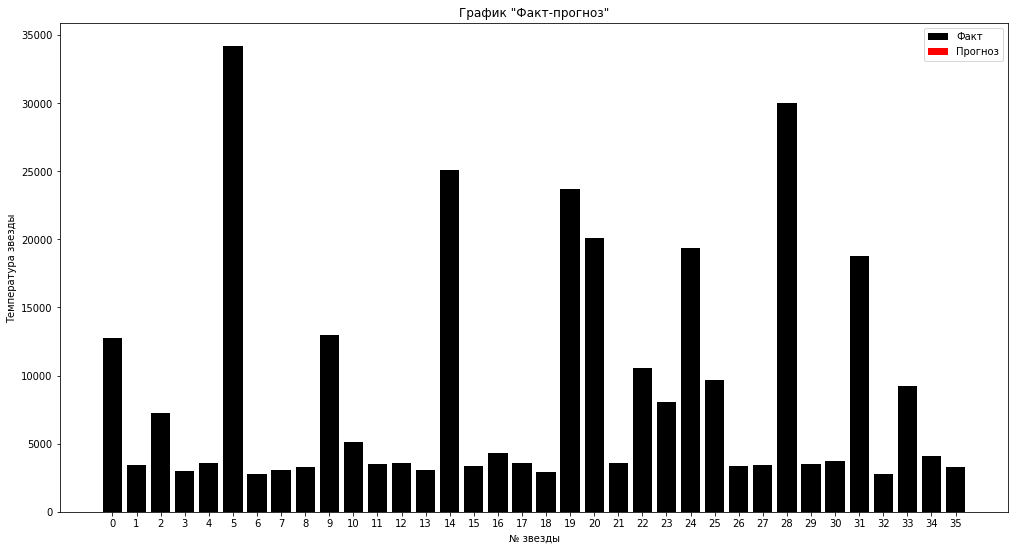

Epoch [101/2000] - Train Loss: 203891360.0000, Val Loss: 135421904.0000
RMSE: 11932.8271


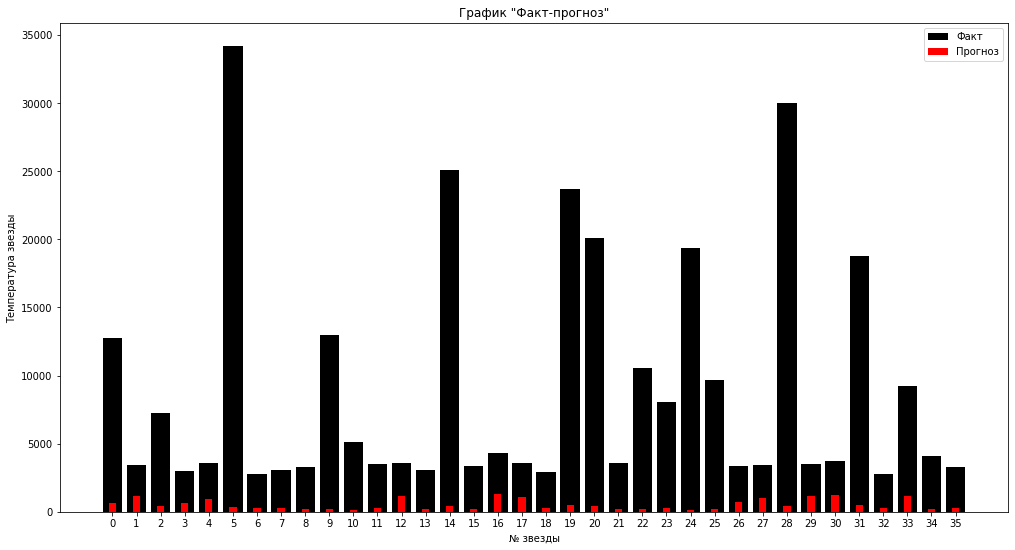

Epoch [201/2000] - Train Loss: 157837917.3333, Val Loss: 88008768.0000
RMSE: 10520.9492


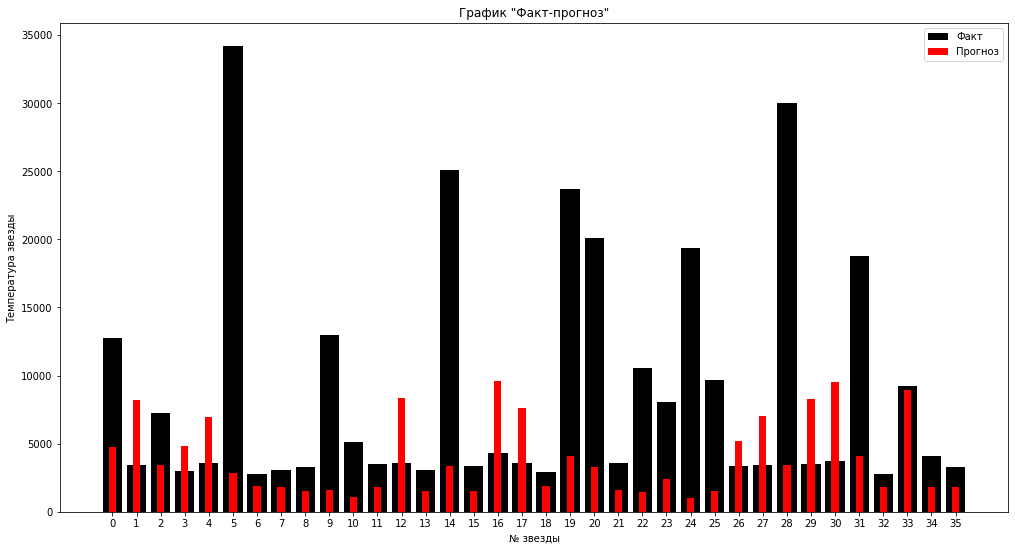

Epoch [301/2000] - Train Loss: 99119117.3333, Val Loss: 57023464.0000
RMSE: 10044.8740


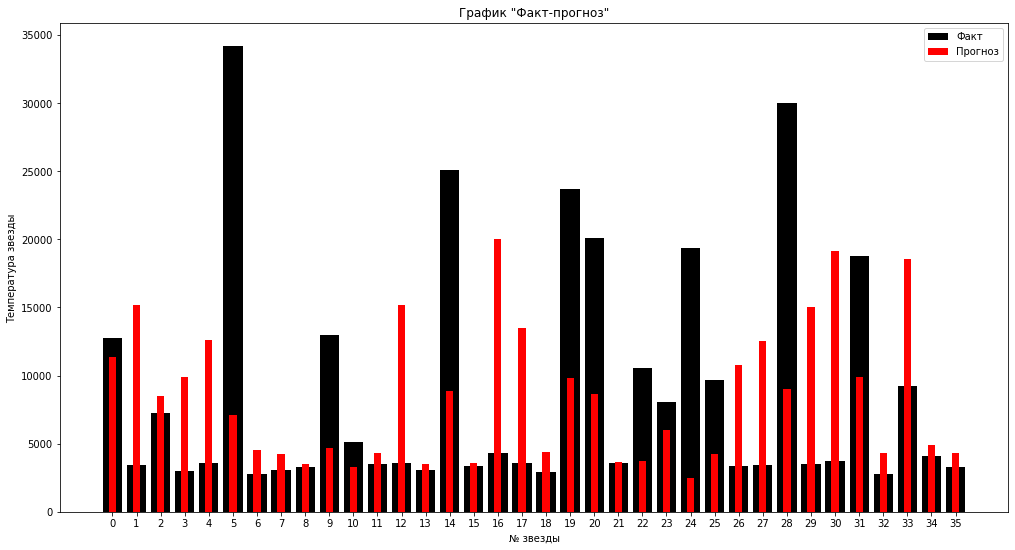

Epoch [401/2000] - Train Loss: 81819438.6667, Val Loss: 45712408.0000
RMSE: 9457.8203


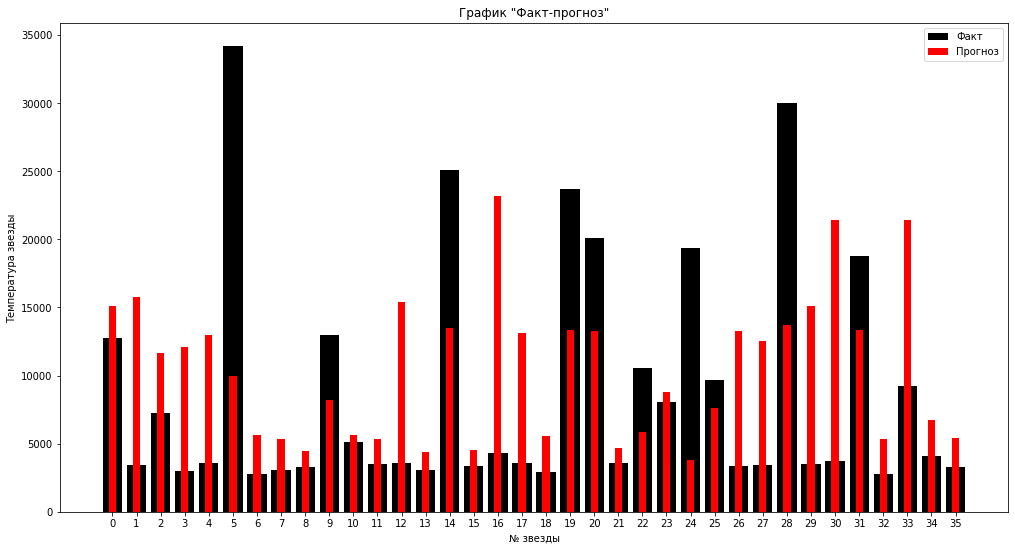

Epoch [501/2000] - Train Loss: 67235570.6667, Val Loss: 38186288.0000
RMSE: 8530.8818


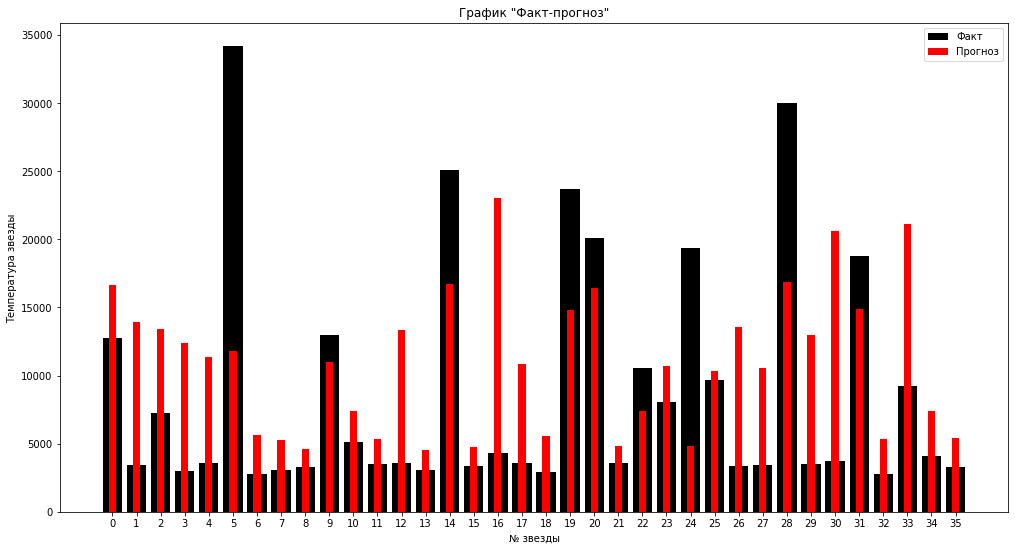

Epoch [601/2000] - Train Loss: 57784424.0000, Val Loss: 33180536.0000
RMSE: 7738.9805


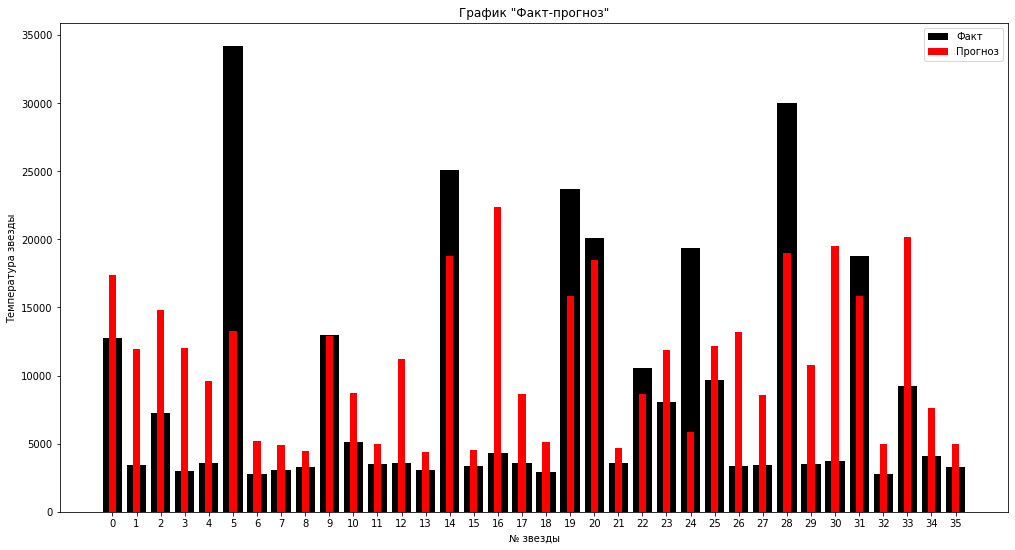

Epoch [701/2000] - Train Loss: 54831646.6667, Val Loss: 30155822.0000
RMSE: 7283.8354


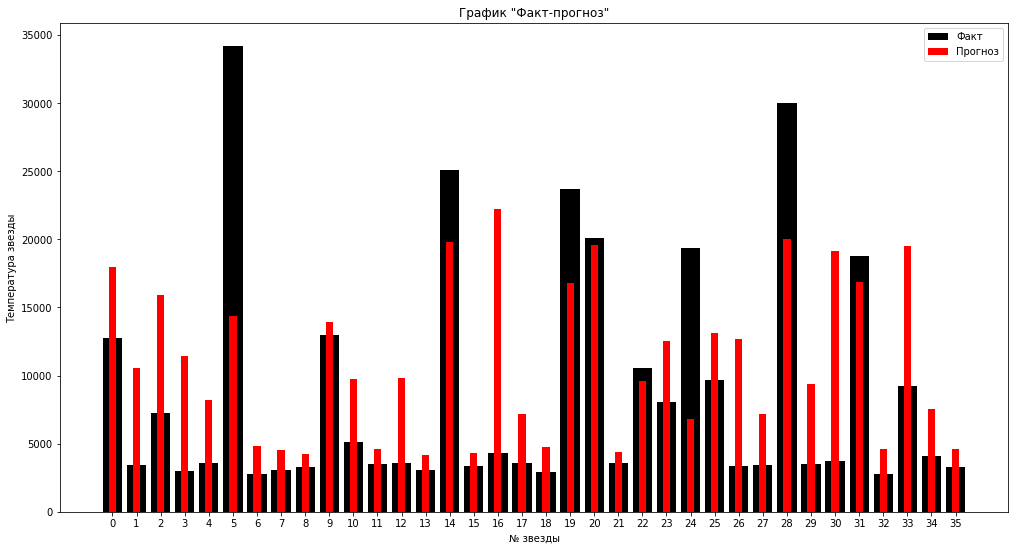

Epoch [801/2000] - Train Loss: 50705341.3333, Val Loss: 27914550.0000
RMSE: 7066.4897


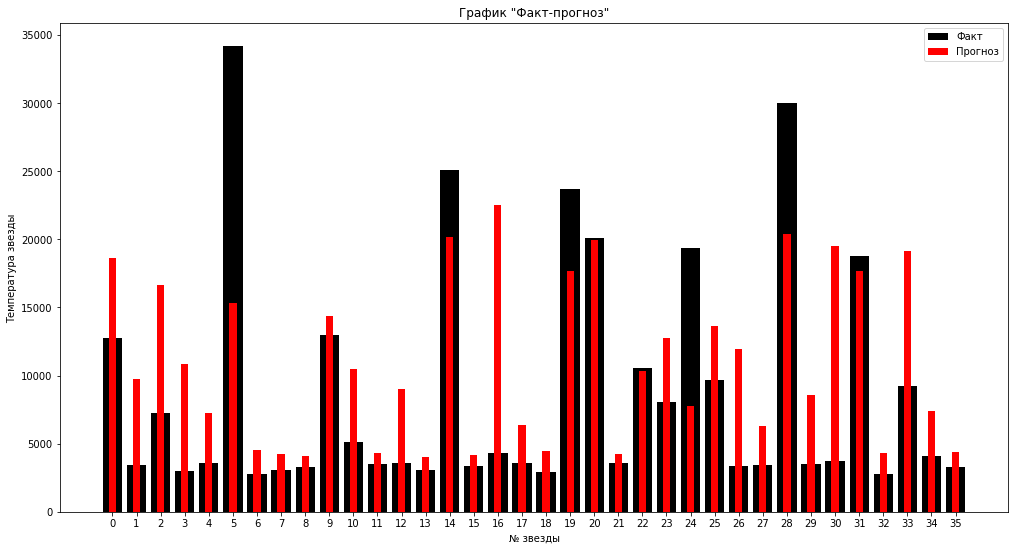

Epoch [901/2000] - Train Loss: 51395353.3333, Val Loss: 26122312.0000
RMSE: 6937.7793


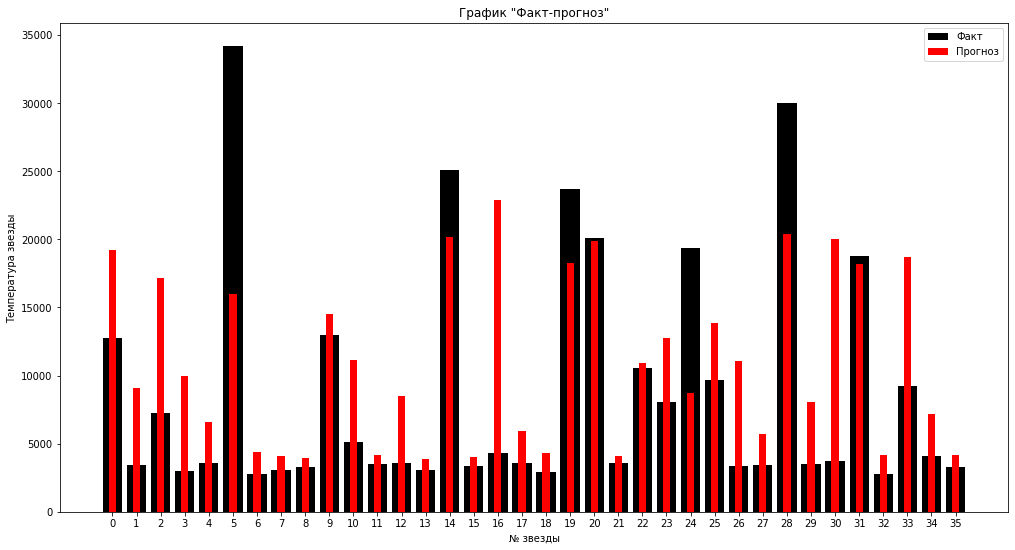

Epoch [1001/2000] - Train Loss: 42934466.6667, Val Loss: 24667168.0000
RMSE: 6879.9951


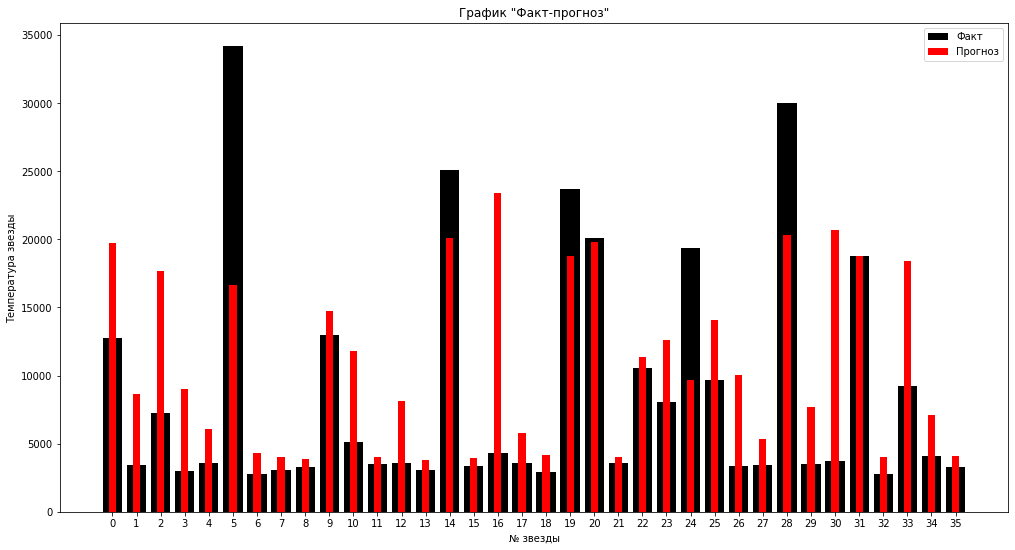

Epoch [1101/2000] - Train Loss: 42814706.0000, Val Loss: 23380764.0000
RMSE: 6848.9209


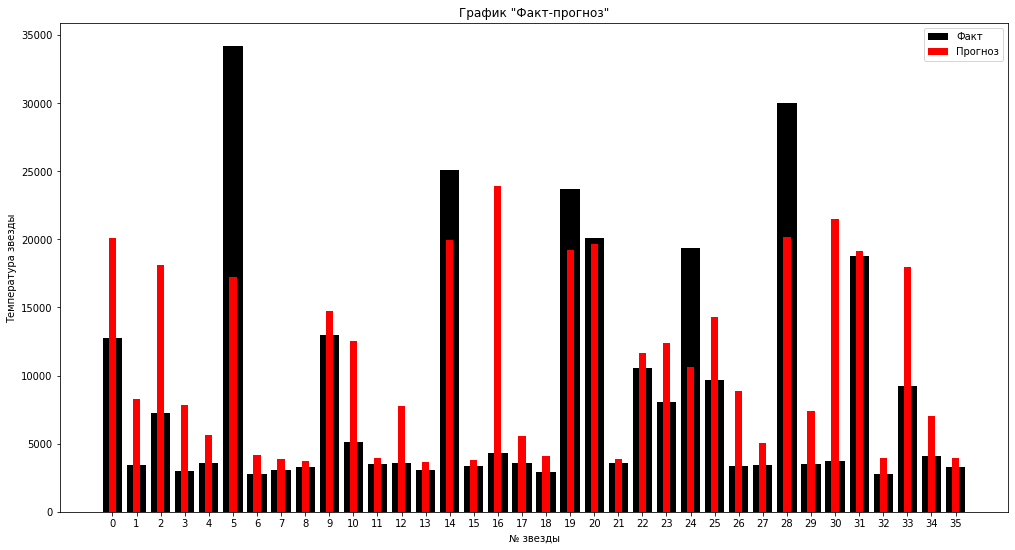

Epoch [1201/2000] - Train Loss: 37939013.3333, Val Loss: 22277464.0000
RMSE: 6889.2070


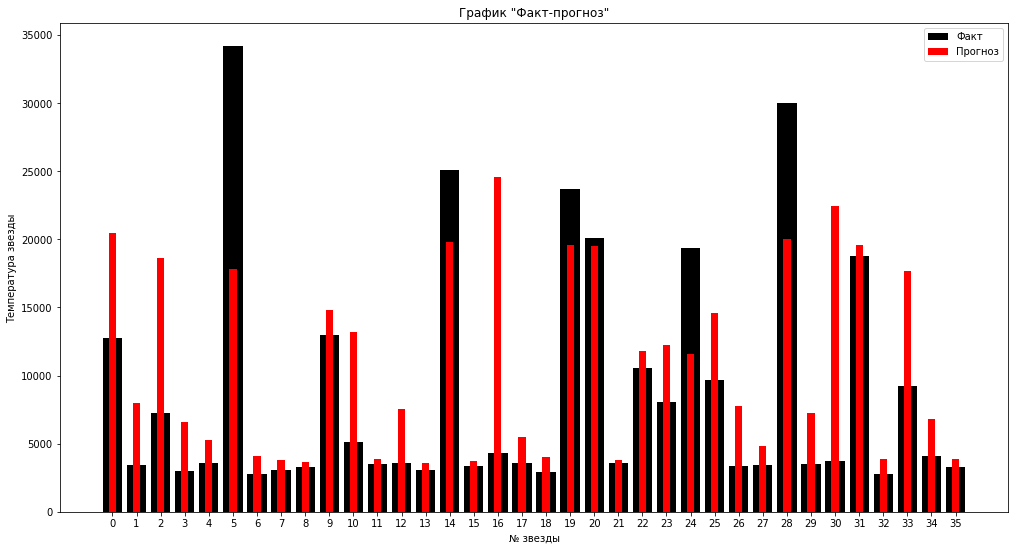

Epoch [1301/2000] - Train Loss: 36014893.3333, Val Loss: 21383572.0000
RMSE: 6945.6401


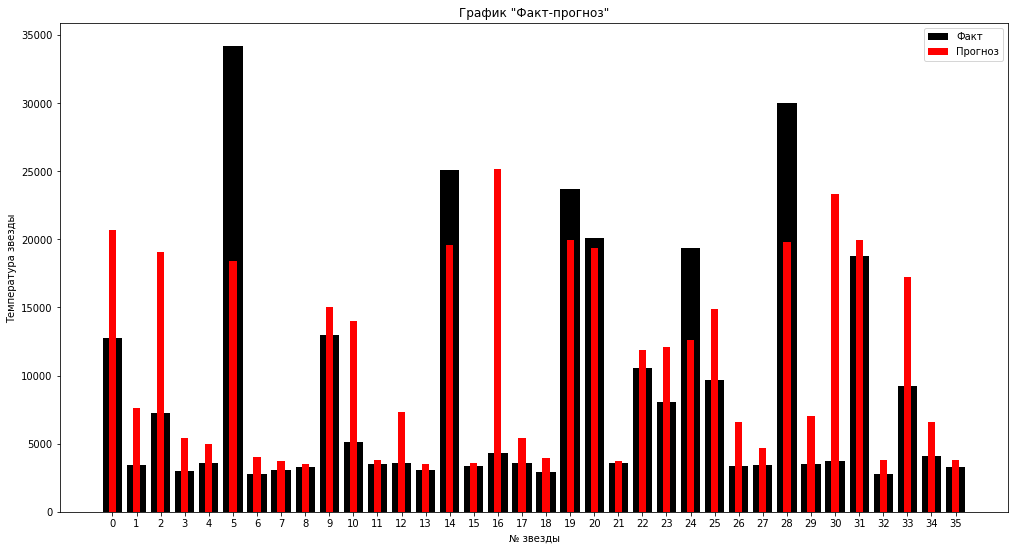

Epoch [1401/2000] - Train Loss: 33693450.0000, Val Loss: 20710742.0000
RMSE: 7067.5054


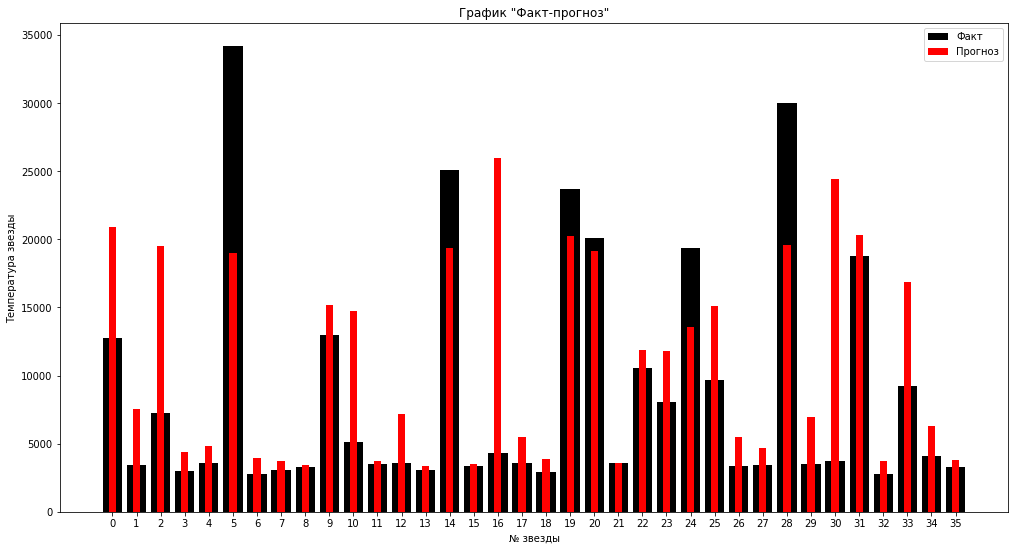

Epoch [1501/2000] - Train Loss: 31313734.6667, Val Loss: 20159304.0000
RMSE: 7214.5698


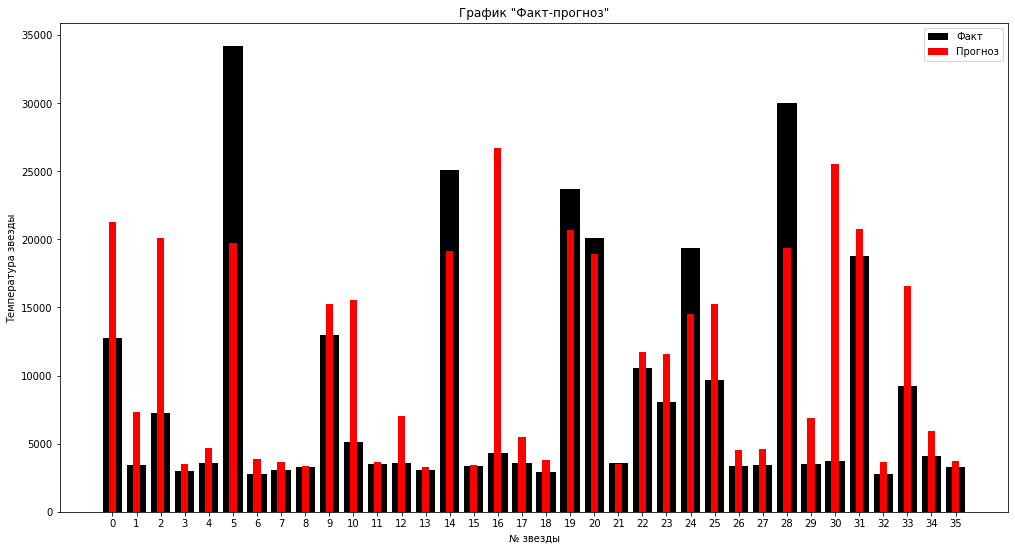

Epoch [1601/2000] - Train Loss: 30447856.0000, Val Loss: 19622040.0000
RMSE: 7305.1558


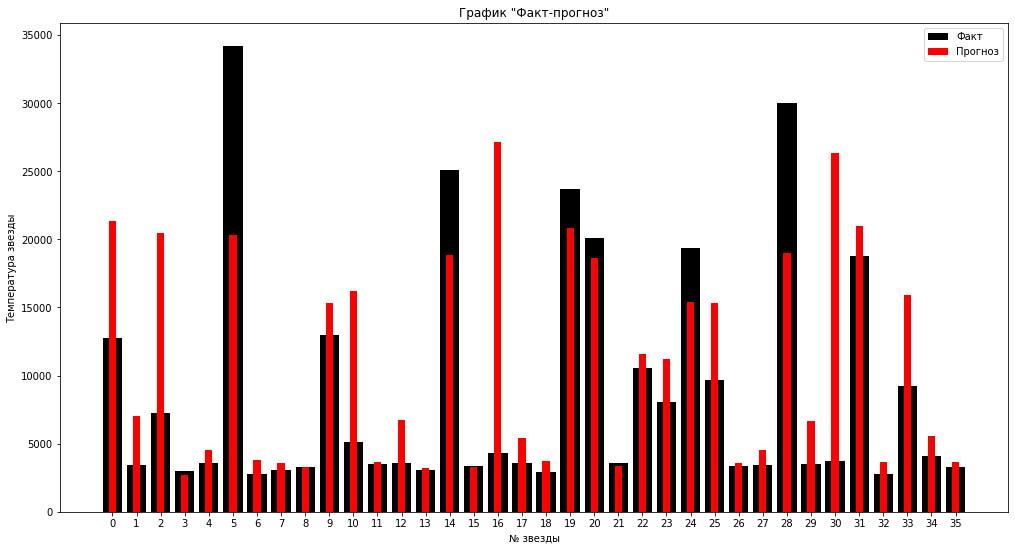

Epoch [1701/2000] - Train Loss: 29059220.0000, Val Loss: 19353768.0000
RMSE: 7435.2930


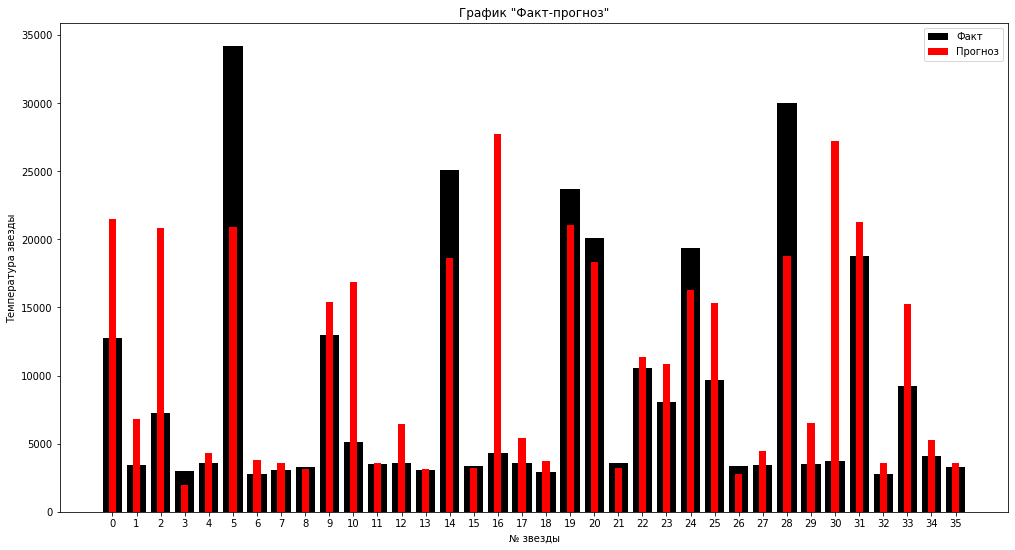

Epoch [1801/2000] - Train Loss: 27437956.6667, Val Loss: 19169050.0000
RMSE: 7579.7114


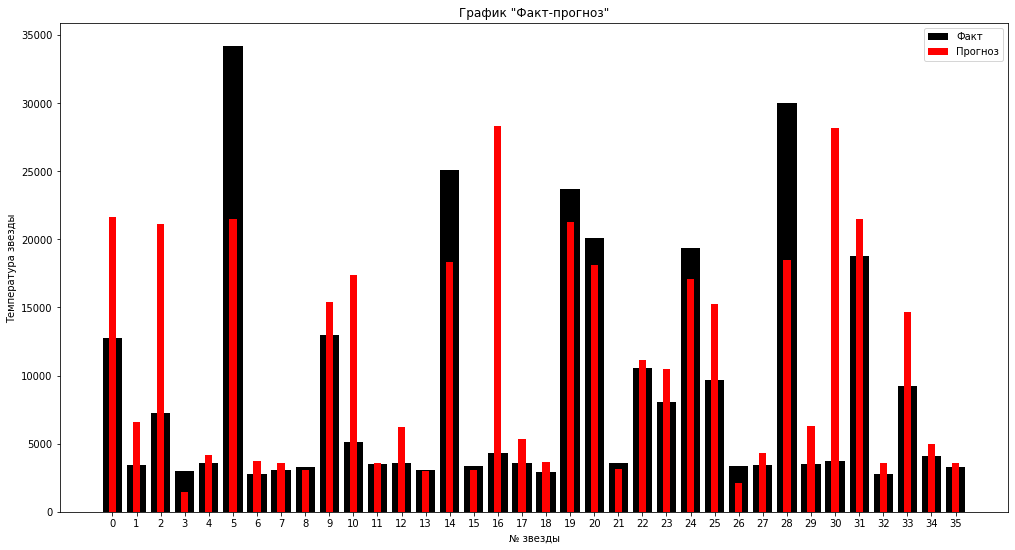

Epoch [1901/2000] - Train Loss: 25330914.6667, Val Loss: 19007058.0000
RMSE: 7665.0635


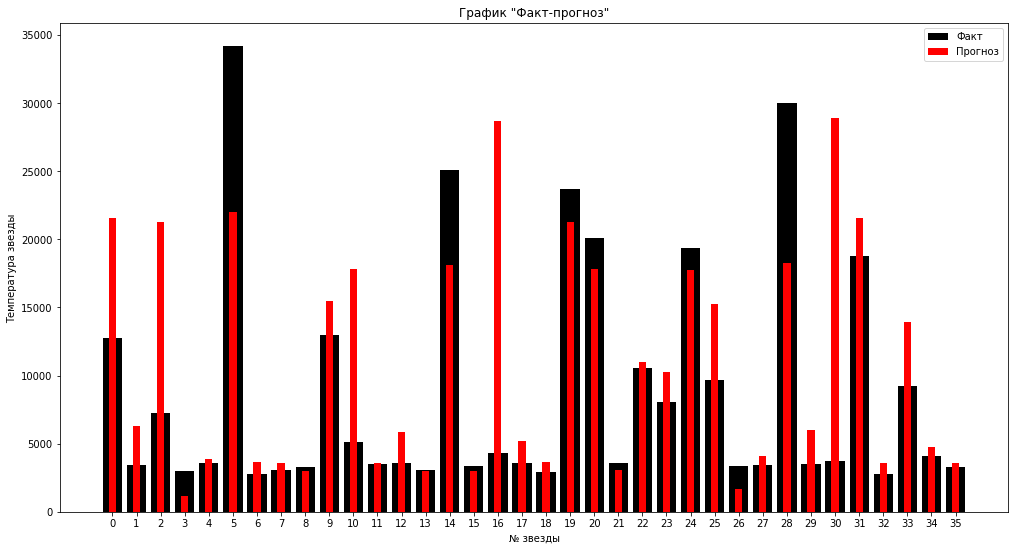

In [31]:
input_size = X_train_processed.shape[1]
hidden_size1 = 64
hidden_size2 = 32

model = NeuralNet(input_size, hidden_size1, hidden_size2)
model.float()
train(model, train_loader, val_loader, test_loader, num_epochs=2000, learning_rate=0.001)

Тестирование модели

In [32]:
def test(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    forecast_temperatures = []
    fact_temperatures = []
    
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
            
            forecast_temperatures.extend(outputs.cpu().numpy().flatten())
            fact_temperatures.extend(targets.cpu().numpy().flatten())
    
    test_loss /= len(test_loader)
    
    # RMSE
    rmse_value = rmse(fact_temperatures, forecast_temperatures)
    # RMSE
    
    print(f"Test Loss: {test_loss:.4f}, Test RMSE: {rmse_value:.4f}")

    x = np.arange(len(fact_temperatures))
    y1 = np.array(forecast_temperatures).flatten()
    y2 = np.array(fact_temperatures).flatten()

    fig, ax = plt.subplots(figsize=(17, 9))
    ax.set_xticks(x)

    ax.bar(x, y2, width=0.8, label='Факт', color='black')
    ax.bar(x, y1, width=0.3, label='Прогноз', color='red')
    
    ax.legend()
    ax.set_title('График "Факт-прогноз"')
    ax.set_xlabel('№ звезды')
    ax.set_ylabel('Температура звезды')
    plt.show()

Test Loss: 60403400.0000, Test RMSE: 7771.9629


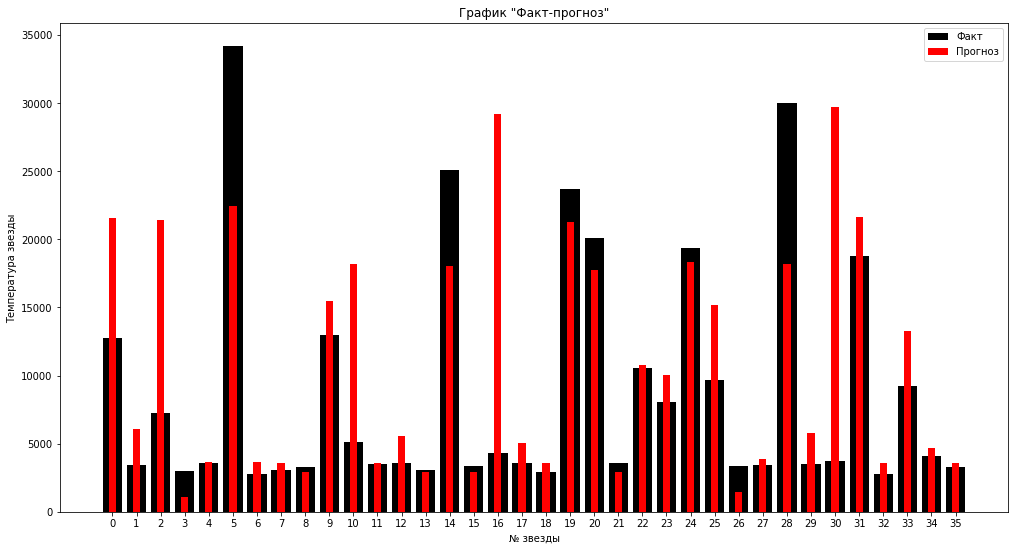

In [33]:
criterion = nn.MSELoss()
test(model, test_loader, criterion)

## Улучшение нейронной сети

In [34]:
class Model_improve(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons, 
                 dropout_1, dropout_2, activation_1, activation_2):
        super(Model_improve, self).__init__()

        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1, bias=True).float()
        self.a1 = activation_1
        self.drop1 = nn.Dropout(dropout_1)

        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2, bias=True).float()
        self.a2 = activation_2
        self.drop2 = nn.Dropout(dropout_2)

        self.fc3 = nn.Linear(n_hidden_neurons_2, n_out_neurons, bias=True).float()

    def forward(self, x):
        x = self.drop1(self.a1(self.fc1(x.float())))
        x = self.drop2(self.a2(self.fc2(x.float())))
        x =self.fc3(x)
        return x  

Определение гиперпараметров для подбора

In [35]:
params = {
    'module__dropout_1': [0, 0.1],
    'module__dropout_2': [0, 0.1],
    'module__n_hidden_neurons_1': range(5, 35, 5),
    'module__n_hidden_neurons_2': range(5, 35, 5),
    'module__activation_1': [nn.ReLU(), nn.ReLU()],
    'module__activation_2': [nn.ReLU(), nn.ReLU()],
    'module__n_in_neurons': [X_train_processed.shape[1]],
    'module__n_out_neurons': [1]
}

Определение RMSE скорера

In [36]:
rmse_scorer = make_scorer(rmse)

Создание экземпляра улучшенной нейросети

In [37]:
skorch_regressor = NeuralNetRegressor(module=Model_improve, 
                                      device='cpu',  
                                      verbose=0,
                                      batch_size=32,
                                      optimizer=torch.optim.Adam, 
                                      max_epochs=10000, 
                                      lr=1e-3,
                                      train_split=ValidSplit(cv=5),
                                      criterion =nn.MSELoss,
                                      callbacks=[
                ('val_rmse', EpochScoring(scoring=rmse_scorer, lower_is_better=True, name='RMSE')),
                ('estoper', EarlyStopping( lower_is_better=True, monitor='RMSE', patience=60)),
            ],
                                     )

Объединим обучающую выборку с валидационной

In [38]:
X_train_val_processed = np.concatenate([X_train_processed, X_val_processed])

In [39]:
y_train_val = np.concatenate([y_train, y_val])

In [40]:
train_val_dataset = StarDataset(torch.tensor(X_train_val_processed, dtype=torch.float32), torch.tensor(y_train_val, dtype=torch.float32).view(-1, 1))

In [41]:
grid = RandomizedSearchCV(
    skorch_regressor,
    params,
    n_jobs=-1,
    cv=3,
    scoring="neg_root_mean_squared_error",
    verbose=3
)

In [42]:
grid.fit(X_train_val_processed, y_train_val.reshape(-1, 1))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3] END module__activation_1=ReLU(), module__activation_2=ReLU(), module__dropout_1=0.1, module__dropout_2=0.1, module__n_hidden_neurons_1=15, module__n_hidden_neurons_2=20, module__n_in_neurons=10, module__n_out_neurons=1;, score=-6616.080 total time=  26.3s
[CV 2/3] END module__activation_1=ReLU(), module__activation_2=ReLU(), module__dropout_1=0.1, module__dropout_2=0.1, module__n_hidden_neurons_1=15, module__n_hidden_neurons_2=20, module__n_in_neurons=10, module__n_out_neurons=1;, score=-6178.027 total time=  21.2s
[CV 3/3] END module__activation_1=ReLU(), module__activation_2=ReLU(), module__dropout_1=0.1, module__dropout_2=0.1, module__n_hidden_neurons_1=15, module__n_hidden_neurons_2=20, module__n_in_neurons=10, module__n_out_neurons=1;, score=-5011.041 total time=  22.3s
[CV 1/3] END module__activation_1=ReLU(), module__activation_2=ReLU(), module__dropout_1=0.1, module__dropout_2=0, module__n_hidden_neurons_1=25

RandomizedSearchCV(cv=3,
                   estimator=<class 'skorch.regressor.NeuralNetRegressor'>[uninitialized](
  module=<class '__main__.Model_improve'>,
),
                   n_jobs=-1,
                   param_distributions={'module__activation_1': [ReLU(),
                                                                 ReLU()],
                                        'module__activation_2': [ReLU(),
                                                                 ReLU()],
                                        'module__dropout_1': [0, 0.1],
                                        'module__dropout_2': [0, 0.1],
                                        'module__n_hidden_neurons_1': range(5, 35, 5),
                                        'module__n_hidden_neurons_2': range(5, 35, 5),
                                        'module__n_in_neurons': [10],
                                        'module__n_out_neurons': [1]},
                   scoring='neg_root_mean_squared_error', verbose=3)

In [43]:
grid.best_score_

-5433.523763020833

In [44]:
best_estimator = grid.best_estimator_

In [45]:
best_predictions = best_estimator.predict(X_test_processed)

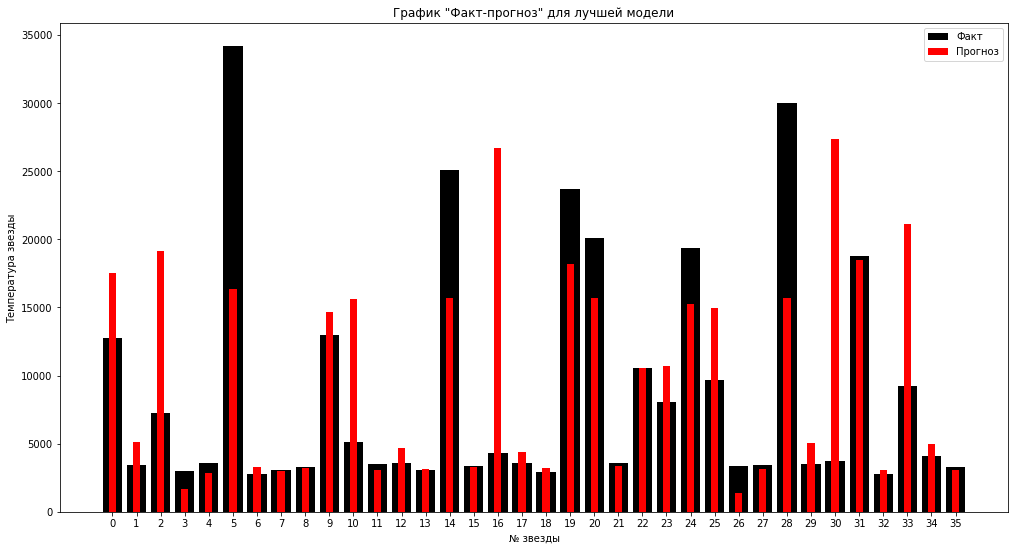

In [46]:
x = np.arange(len(y_test))
y1 = best_predictions.flatten()
y2 = y_test.to_numpy().flatten()

fig, ax = plt.subplots(figsize=(17, 9))
ax.set_xticks(x)

ax.bar(x, y2, width=0.8, label='Факт', color='black')
ax.bar(x, y1, width=0.3, label='Прогноз', color='red')

ax.legend()
ax.set_title('График "Факт-прогноз" для лучшей модели')
ax.set_xlabel('№ звезды')
ax.set_ylabel('Температура звезды')
plt.show()

In [47]:
rmse_best = np.sqrt(mean_squared_error(y_test, best_predictions))

In [48]:
print(f"RMSE for best predictions: {rmse_best:.4f}")

RMSE for best predictions: 7831.5076


## Выводы

Данная работа направлена на построение и оценку моделей регрессии нейронных сетей для прогнозирования температур звезд. Она охватывает предобработку данных, создание модели, обучение, валидацию, настройку гиперпараметров и визуализацию. 
<br>
<br>
<li>
Предобработка данных: Код выполняет предобработку данных с использованием ColumnTransformer для масштабирования числовых признаков и кодирования категориальных признаков. Это гарантирует, что признаки находятся в подходящем формате для обучения моделей машинного обучения.

<li>
Разделение на обучающую, валидационную и тестовую выборки: Данные разделяются на обучающий, валидационный и тестовый наборы с использованием функции train_test_split. Это важно для точной оценки и проверки производительности модели.

<li>
Модель нейронной сети: Определена модель нейронной сети с использованием класса nn.Module из библиотеки PyTorch. Архитектура включает несколько слоев с функциями активации.

<li>
Обучение и валидация: В цикле обучения выполняется перебор набора данных и обновление весов модели с использованием алгоритма обратного распространения ошибки. Также реализовано преждевременное прекращение обучения для предотвращения переобучения и экономии времени.

<li>
Метрики оценки: Код использует среднеквадратичную ошибку (MSE) в качестве функции потерь для обучения модели. Кроме того, вычисляется корень из среднеквадратичной ошибки (RMSE) для оценки производительности модели на валидационном наборе данных.

<li>
Настройка гиперпараметров: В коде используется RandomizedSearchCV из библиотеки scikit-learn для выполнения настройки гиперпараметров. Он ищет оптимальные гиперпараметры, оценивая различные комбинации с использованием перекрестной проверки.
    
<li>
Визуализация: Код включает визуализацию для отображения графика "Факт-Прогноз", который сравнивает фактические и предсказанные температуры.

Улучшение модели: Определена улучшенная модель нейронной сети с дополнительными слоями и слоями dropout для исследования потенциального улучшения производительности.

Заключение: Проблемы, с которыми столкнулся код, включают несогласованное разделение данных и несоответствие параметров между пространством поиска и моделью. Эти проблемы были устранены путем обеспечения согласованного разделения данных и выравнивания имен параметров.